# US Medical Insurance Cost

In this project, a **CSV** file with medical insurance costs will be investigated using Python fundamentals and ML algorithims. My goal is to find an effective model to predict the insurance costs by using various attributes of isurance policyholders. 

In [160]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import seaborn as sns

# Dataset and Predictors


In [163]:
#Load data into a dataframe
insurance = pd.read_csv('insurance.csv')

In [164]:
#check the head of dataframe
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


6 data fields about insurance policyholders as below 
* age: policyholder's age / integer variable
* sex: policyholder's sex / string variable
* bmi: policyholder's Body Mass Index / float variable - BMI is used for defining a person's weight category (normal weight, overweight, obese) 
* children: the number of children a policyholder has / integer variable
* smoker: policyholder smoking or not / string variable
* region: a region where a policyholder lives / string variable 
* charges: amount of charges a policyholder pays / float variable

In [173]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [174]:
#Detect missing values
insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

I will start with all columns that I have and eliminate any columns that have least statistical significance.  

In [175]:
#Select my predictos
x = insurance [['age', 'sex', 'bmi', 'children', 'smoker', 'region']]

In [176]:
#Select my response
y= insurance['charges']

As shown in the above data field introduction, the following columns: sex,smoker,region contain string variables. <br> Mulitple linear regression model is algebraic where all of your inputs have to be numeric. Thus, I will transform these categorical variables into numerical variables. 


1. sex - transform this into binary variable
0: male 1:female

In [177]:
x['sex_n'] = x['sex'].map({'male':0,'female':1})

2. smoker - 0: no 1: yes 

In [178]:
x['smoker_n'] = x['smoker'].map({'yes':1,'no':0})

3. region

In [182]:
#Checking the number of levels for the column:region
x.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

There are 4 levels for 'region'. One can think of assigning numerical labels to these regions, but these regions don't have intrinsic ordering between them. For example. value 3 (northeast) is not greater than value 1(southwest).

Thus, I will create dummy variables. One-hot ecoding scheme is applied to tranform this variable into 4 binary variables. 

In [138]:
x.southwest.value_counts()

0    1013
1     325
Name: southwest, dtype: int64

In [139]:
x.northwest.value_counts()

0    1013
1     325
Name: northwest, dtype: int64

In [140]:
x.southeast.value_counts()

0    974
1    364
Name: southeast, dtype: int64

I need to re-select the predictors

In [141]:
x= x[['age', 'sex_n', 'bmi', 'children', 'smoker_n', 'southeast','northwest','southwest']]

I will use statsmodels regression to pull of the p-values of each predictor - I wanted to be consistent by using Scikit-learn to find the p-values but many from my google search recommended to use statsmodel. I'm wondering if I'm being reasonable to use statsmodel to find my predictors' statistical signifance and go back to scikit learn to train and test my data to see if my model is effective. 

In [142]:
model = sm.OLS(y,x)

In [143]:
fit_model = model.fit()

In [144]:
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                charges   R-squared (uncentered):                   0.874
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                              1158.
Date:                Wed, 18 Nov 2020   Prob (F-statistic):                        0.00
Time:                        20:32:19   Log-Likelihood:                         -13617.
No. Observations:                1338   AIC:                                  2.725e+04
Df Residuals:                    1330   BIC:                                  2.729e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          204.8859     11.681     17.540      0.000     181.970     227.802
sex_n       -680.1347    343.383     -1.981      0.048   -1353.766      -6.504
bmi           67.3454     18.570      3.626      0.000      30.915     103.776
children     281.9133    144.126      1.956      0.051      -0.825     564.651
smoker_n    2.326e+04    431.979     53.836      0.000    2.24e+04    2.41e+04
southeast  -1271.9588    503.651     -2.525      0.012   -2259.995    -283.922
northwest  -1710.4123    487.357     -3.510      0.000   -2666.484    -754.341
southwest  -1930.5262    496.107     -3.891      0.000   -2903.763    -957.289
==============================================================================
Omnibus:                      279.847   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              659.841
Skew:                           1.137   Prob(JB):                    5.22e-144
Kurtosis:                       5.581   Cond. No.                         206.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value of 'children' is the largest (.051) but still low enough to add it to the model since my threshold is .05 ish. 

In [145]:
x

,age,sex_n,bmi,children,smoker_n,southeast,northwest,southwest
0,19,1,27.900,0,1,0,0,1
1,18,0,33.770,1,0,1,0,0
2,28,0,33.000,3,0,1,0,0
3,33,0,22.705,0,0,0,1,0
4,32,0,28.880,0,0,0,1,0
...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,0,1,0
1334,18,1,31.920,0,0,0,0,0
1335,18,1,36.850,0,0,1,0,0
1336,21,1,25.800,0,0,0,0,1


Before building a model, I will split the data into the training set and the test set. 80% of the data were allocated to the training set

In [146]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=.8,random_state=5)

In [147]:
x_train.shape

(1070, 8)

In [148]:
x_test.shape

(268, 8)

In [149]:
x.describe()

,age,sex_n,bmi,children,smoker_n,southeast,northwest,southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.494768,30.663397,1.094918,0.204783,0.272048,0.242900,0.242900
std,14.049960,0.500160,6.098187,1.205493,0.403694,0.445181,0.428995,0.428995
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,0.000000,26.296250,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,0.000000,30.400000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,1.000000,0.000000,0.000000
max,64.000000,1.000000,53.130000,5.000000,1.000000,1.000000,1.000000,1.000000


I will use multiple linear regression for my model which can predict mdecial insurance charges based on various attributes of an insurnace holder 

Creating a linear regression model and fit it to my x_train and y_train.

In [150]:
mlr = LinearRegression()

In [151]:
mlr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's find out what the coefficient of determination $r^{2}$ for my model!

In [152]:
mlr.score(x_test,y_test)

0.778109660422383

Let's explore the coefficients of the predictors to see if there's anything we can do to improve the model's accuracy

In [153]:
mlr.coef_

array([  256.94295222,   253.53277438,   337.67931668,   552.8415818 ,
       23660.10485472,  -845.43390866,    56.31627462,  -845.69969435])

In [154]:
person12=[[50,0,27,3,0,0,0,0],[50,1,27,3,0,1,0,0]]

In [155]:
mlr.predict(person12)

array([11377.26249459, 10785.36136031])

In [156]:
predicted_y = mlr.predict(x_test)

In [157]:
predicted_y

array([ 2.80196712e+03,  2.76539583e+04,  1.18270033e+04,  4.97128202e+03,
        8.26020179e+03,  3.49800170e+04,  1.17617005e+04,  1.10656352e+04,
        8.36519245e+03,  1.11807200e+04,  1.54682184e+04,  1.09007670e+04,
        5.01084263e+03,  9.23711837e+03,  8.29646110e+03,  8.89074300e+03,
        3.16202402e+04,  1.29482537e+04,  1.32884644e+04,  7.53128170e+03,
        2.86085344e+04,  2.19240932e+03,  3.24354449e+03,  3.79492040e+03,
        2.49018569e+03,  9.70392727e+03,  3.68406266e+04,  1.70945706e+04,
        1.08592745e+04,  1.40876899e+04,  1.33068247e+04,  1.19355775e+03,
        5.92173822e+03,  1.07504608e+04,  3.11483102e+04,  4.12584954e+03,
        6.66635109e+03,  2.80617764e+03,  6.49691422e+03,  5.82769295e+03,
        3.22789584e+03,  3.72470599e+04,  3.06074251e+04,  3.01806687e+04,
        1.05504381e+04,  7.59258815e+03,  3.50081453e+04,  3.46932792e+03,
        1.90740969e+04,  5.29663474e+03,  1.03836281e+04,  2.86003715e+04,
        3.65718423e+03,  

Text(0, 0.5, 'Predicted insurance charge')

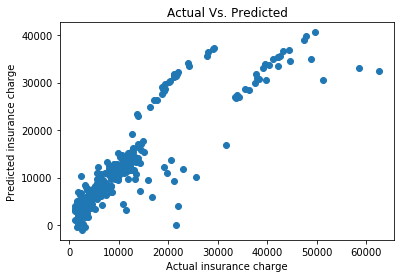

In [158]:
plt.scatter(y_test,predicted_y)
plt.title('Actual Vs. Predicted')
plt.xlabel('Actual insurance charge')
plt.ylabel('Predicted insurance charge')

Based on the graph above and $r^2$, I think my model is fairly effective. Please give me feedback to improve my thought process! Thanks!